In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import pretty_midi
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display

In [2]:
test_path = "/home/t-zeqianju/yuancwang/AmphionOpen/data/opera_midi_clips_long_silence/安排下巧计谋营门不锁 南梆子_1.mid"
pm = pretty_midi.PrettyMIDI(test_path)
print(pm.instruments)

[Instrument(program=0, is_drum=False, name="")]


In [4]:
# Synthesis frequency
fs = 16000
IPython.display.Audio(pm.synthesize(fs=16000), rate=16000)
# Sounds like sine waves...

In [10]:
def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

/tmp/ipykernel_514196/3913294799.py:3: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],


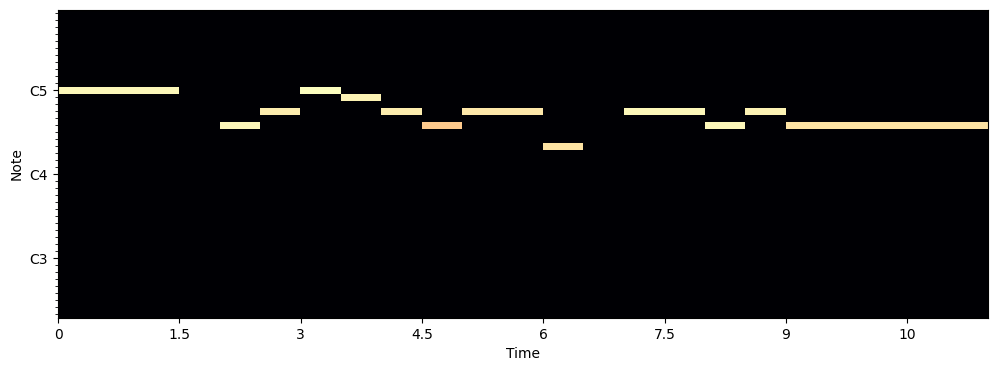

In [26]:
plt.figure(figsize=(12, 4))
plot_piano_roll(pm, 40, 84)

In [ ]:
# Let's look at what's in this MIDI file
print('There are {} time signature changes'.format(len(pm.time_signature_changes)))
print('There are {} instruments'.format(len(pm.instruments)))
print('Instrument 1 has {} notes'.format(len(pm.instruments[0].notes)))
print('Instrument 1 has {} pitch bends'.format(len(pm.instruments[0].pitch_bends)))
print('Instrument 1 has {} control changes'.format(len(pm.instruments[0].control_changes)))

There are 1 time signature changes
There are 1 instruments
Instrument 1 has 13 notes
Instrument 1 has 0 pitch bends
Instrument 1 has 0 control changes


In [ ]:
# for i in range(len(pm.instruments[0].notes)):
#     print(pm.instruments[0].notes[i])

# Tokenizer

In [ ]:
def MIDITokenizer(pm):
    pm = pm.instruments[0]
    tokens = []
    for i in range(len(pm.notes)):
        note = pm.notes[i]
        tokens.append([int(note.start // 0.25), int((note.end - note.start) // 0.25), note.pitch])

    # Sort by start time, if start time is the same, sort by duration
    tokens.sort(key=lambda x: (x[0], -x[1]))

    new_tokens = [tokens[0]]
    for i in range(1, len(tokens)):
        if tokens[i][0] == tokens[i - 1][0]:
            continue
        new_tokens.append(tokens[i])
    tokens = new_tokens

    
    for i in range(len(tokens) - 1):
        if tokens[i + 1][0] - tokens[i][0] == 0:
            print(tokens[i], tokens[i + 1])
        if tokens[i][0] + tokens[i][1] > tokens[i + 1][0]:
            tokens[i][1] = tokens[i + 1][0] - tokens[i][0]


    new_tokens = []
    for i in range(len(tokens) - 1):
        new_tokens.append([tokens[i][1], tokens[i][2]])
        if tokens[i][0] + tokens[i][1] < tokens[i + 1][0]:
            new_tokens.append([tokens[i + 1][0] - tokens[i][0] - tokens[i][1], 0])
    new_tokens.append([tokens[-1][1], tokens[-1][2]])

    return new_tokens

# Processed Data

In [ ]:
saved_path = "/home/t-zeqianju/yuancwang/AmphionOpen/data/processed_data/tokens"
midi_path = "/home/t-zeqianju/yuancwang/AmphionOpen/data/opera_midi_clips_long_silence"

In [ ]:
for midi in os.listdir(midi_path):
    pm = pretty_midi.PrettyMIDI(midi_path + "/" + midi)
    tokens = MIDITokenizer(pm)
    start = 0
    end = 0
    i = 0
    for j in range(len(tokens)):
        if tokens[j][1] == 0 and tokens[j][0] >= 20:
            end = j
            np.save(saved_path + "/" + midi[:-4] + "_" + str(i), tokens[start:end])
            i += 1
            start = j + 1
    if start < len(tokens):
        np.save(saved_path + "/" + midi[:-4] + "_" + str(i), tokens[start:])

# Info of Processed Data

In [ ]:
processed_data_path = "/home/t-zeqianju/yuancwang/AmphionOpen/data/processed_data/tokens"
min_len = 1000000
max_len = -1
duration_dict = {}
pitch_dict = {}
len_dict = {}
for file in os.listdir(processed_data_path):
    tokens = np.load(processed_data_path + "/" + file)
    min_len = min(min_len, len(tokens))
    max_len = max(max_len, len(tokens))
    len_dict[len(tokens)] = len_dict.get(len(tokens), 0) + 1
    for token in tokens:
        if token[0] not in duration_dict:
            duration_dict[token[0]] = 1
        else:
            duration_dict[token[0]] += 1
    for token in tokens:
        if token[1] not in pitch_dict:
            pitch_dict[token[1]] = 1
        else:
            pitch_dict[token[1]] += 1
print("max len and min len:", min_len, max_len)
print(duration_dict)
print("max duration:", max(duration_dict.keys()))
print("min duration:", min(duration_dict.keys()))
print(pitch_dict)
print("max pitch:", max(pitch_dict.keys()))
print("min pitch:", min(pitch_dict.keys()))
print("total_files:", sum(len_dict.values()))
useful_file_num = 0
for k, v in len_dict.items():
    if k > 10 and k < 2000:
        useful_file_num += v
print("useful_file_num:", useful_file_num)

max len and min len: 1 5703
{4: 5496, 3: 4745, 1: 96584, 2: 32074, 8: 616, 0: 30214, 5: 480, 9: 103, 6: 976, 10: 192, 7: 273, 13: 32, 16: 53, 12: 150, 15: 31, 18: 38, 14: 68, 20: 11, 11: 90, 17: 19, 24: 8, 26: 4, 30: 3, 19: 8, 32: 2, 28: 3, 34: 2, 22: 7, 36: 1, 52: 1, 23: 1}
max duration: 52
min duration: 0
{74: 8319, 72: 7321, 0: 44901, 64: 13732, 69: 12411, 67: 13140, 60: 9053, 57: 11394, 55: 6591, 52: 1402, 59: 5007, 62: 14038, 53: 191, 79: 4908, 76: 6896, 77: 1061, 65: 1788, 71: 3768, 50: 243, 81: 3562, 84: 1224, 83: 758, 86: 372, 88: 80, 54: 17, 48: 11, 47: 12, 66: 21, 91: 52, 61: 3, 73: 1, 70: 2, 78: 3, 68: 1, 56: 1, 80: 1}
max pitch: 91
min pitch: 0
total_files: 727
useful_file_num: 573


In [ ]:
# create json
token_path = "/home/t-zeqianju/yuancwang/AmphionOpen/data/processed_data/tokens"
json_list = []
for file in os.listdir(token_path):
    tokens = np.load(token_path + "/" + file)
    if len(tokens) > 2000:
        print(file)
    uid = file[:-4]
    if len(tokens) > 10 and len(tokens) < 2000:
        json_list.append({"Dataset": "Opera", "tokens": tokens.tolist(), "Uid": uid, "token_num": len(tokens)})
print(json_list[0])
import json
with open("/home/t-zeqianju/yuancwang/AmphionOpen/data/processed_data/train.json", "w", encoding="utf-8") as f:
    json.dump(json_list, f, ensure_ascii=False, indent=4)

P348 承畴儿为国家松山丧命-二黄散板-导板-回龙-反二黄慢板-原板_2_0.npy
p320见灵堂不由人珠泪滚滚-二黄导板-散板-反二黄慢板-原板_1_0.npy
P105 父子们在宫院伤心落泪-二黄导板-回龙-原板-慢板-垛板-散板_1_0.npy
P331 孙淑琳出店房前思后想-二黄慢板_1_0.npy
P163 谯楼上二更鼓声声送听-西皮慢板-原板-二六-摇板_1_0.npy
P324 刘清提在都城浑身颤抖-二黄导板-回龙-慢板-原板_3_0.npy
P117 胸有朝阳-二黄导板-回龙-慢板-快三眼-原板-二六_3_0.npy
P329 窦太真在昭阳前思后想-二黄慢板_1_0.npy
P114 雄心壮志冲云天-二黄导板-回龙-原板-慢三眼-原板-垛板_7_0.npy
P102 想去岁中秋节相逢甚巧-二黄慢板-散板_1_0.npy
P108 恨不得把吴狗倾国灭尽-二黄慢板_1_0.npy
P345 捧一盏热茶儿寒肠回暖-反二黄慢板-摇板-原板_1_0.npy
P174 没来由遭刑宪受此大难-反二黄慢板_1_0.npy
P125 忽听得侍儿们一声来请反二黄导板-回龙-慢板_3_0.npy
P352 我的家祖居南阳地-反二黄慢板-慢原板-快二六-慢板-原板-摇板-快二六-快板_1_0.npy
{'Dataset': 'Opera', 'tokens': [[4, 74], [3, 72], [1, 74], [4, 72], [2, 0], [2, 72], [3, 64], [1, 69], [4, 67], [3, 67], [1, 69], [4, 72], [4, 69], [2, 0], [2, 64], [3, 64], [1, 69], [4, 67]], 'Uid': '猛听得金鼓响 西皮流水_1_0', 'token_num': 18}


# Tokens to MIDI

In [29]:
tokens = np.load("/home/t-zeqianju/yuancwang/AmphionOpen/data/processed_data/tokens/碧云天黄花地西风紧 反二黄散板 回龙_4_0.npy")

In [9]:
def generate_pm(tokens):
    new_pm = pretty_midi.PrettyMIDI()
    new_pm.instruments.append(pretty_midi.Instrument(0))
    print(new_pm.instruments)
    start = 0.
    for token in tokens:
        pitch = token[1]
        start = start
        end = start + token[0] * 0.25
        new_pm.instruments[0].notes.append(pretty_midi.Note(velocity=100, pitch=pitch, start=start, end=end))
        start = end
    return new_pm
# new_pm = generate_pm(tokens)
# IPython.display.Audio(new_pm.synthesize(fs=16000), rate=16000)

/tmp/ipykernel_514196/3913294799.py:3: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],


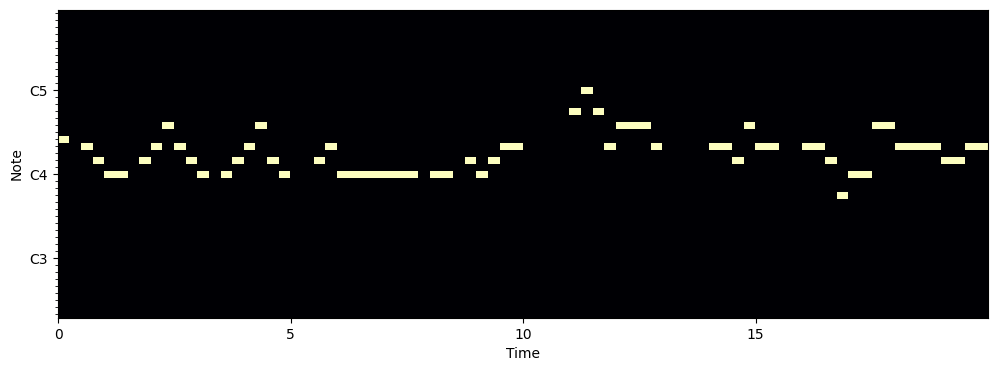

In [31]:
plt.figure(figsize=(12, 4))
plot_piano_roll(new_pm, 40, 84)

# Inference

In [ ]:
from transformers import LlamaForCausalLM, LlamaConfig, LlamaModel
llama_config = LlamaConfig(vocab_size=256,
                           hidden_size=1024,
                           intermediate_size=4096,
                           num_hidden_layers=12,
                           num_attention_heads=16,
                           pad_token_id=250,
                           bos_token_id=251,
                           eos_token_id=252,)
model_path = "/blob/v-yuancwang/amphion_ttmidi/ttmidi_mini_llama/checkpoint/epoch-0020_step-0012033_loss-0.676154/pytorch_model.bin"
llama_model = LlamaForCausalLM.from_pretrained(model_path, config=llama_config)
# print(llama_model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
llama_model.to(device)

# Inference from random

In [20]:
generate_ids = llama_model.generate(input_ids=torch.tensor([[251]], device=device),
                                    max_length=200,
                                    pad_token_id=250,
                                    eos_token_id=252,
                                    do_sample=True,
                                    temperature=0.8)
print(generate_ids)

tensor([[251,   1,  55,  ...,   1,  57,   1]], device='cuda:0')


In [21]:
tokens = generate_ids[0].cpu().numpy()
tokens = tokens[1:-1]
# 1d -> 2d
tokens = tokens.reshape(-1, 2)
tokens = tokens.tolist()
new_pm = generate_pm(tokens)
IPython.display.Audio(new_pm.synthesize(fs=16000), rate=16000)

[Instrument(program=0, is_drum=False, name="")]


/tmp/ipykernel_569623/3913294799.py:3: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],


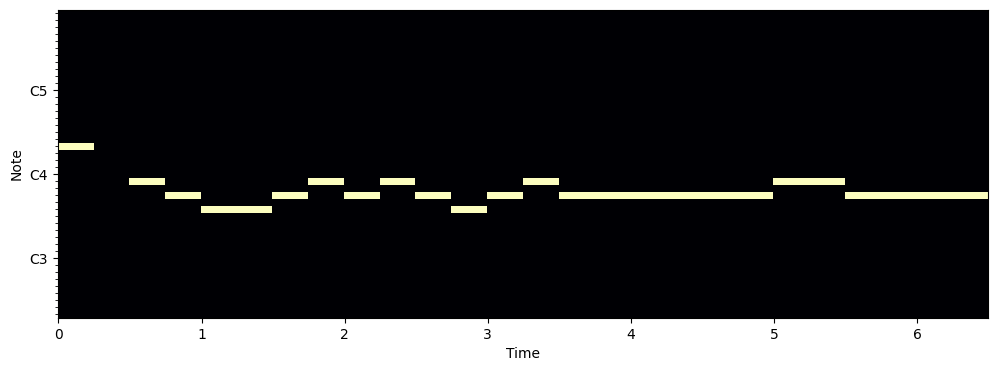

In [ ]:
plt.figure(figsize=(12, 4))
plot_piano_roll(new_pm, 40, 84)